# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: Holt-Winters


# Example: Holt-Winters Hyperparameter

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import statistics
from math import inf
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
from matplotlib import pyplot
import matplotlib.pyplot as plt
from river import anomaly
from river import compose
from river import preprocessing
from river import linear_model
from river import datasets
from river import metrics
from river import time_series
from river import utils
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot

### 1 Example from River - The Objective Function

* This is the Holt-Winters example taken from [https://riverml.xyz/0.14.0/api/time-series/HoltWinters/](https://riverml.xyz/0.14.0/api/time-series/HoltWinters/)
* It is used to check whether the implementation can be executed.
* Finally, the objective function is added.

In [2]:
dataset = datasets.AirlinePassengers()

model = time_series.HoltWinters(
     alpha=0.3,
     beta=0.1,
     gamma=0.6,
     seasonality=12,
     multiplicative=True
 )

metric = metrics.MAE()

res = time_series.evaluate(
     dataset = dataset,
     model=model,
     metric= metric,
     horizon=12,
     agg_func=statistics.mean,
 )
res

mean(MAE): 28.766848

In [3]:
type(res.get())

float

In [4]:
from river import utils
from river import datasets
from river import metrics
import statistics
def evaluate_ts_model(model, dataset, time_interval = "month", window_size = 12):
    metric = utils.Rolling(obj=metrics.MAE(), window_size=window_size)
    dates = []
    y_trues = []
    y_preds = []
    for x, y in dataset:
        # Obtain the prior prediction and update the model in one go
        y_pred = model.forecast(horizon=1)[0]
        model.learn_one(y)
        # Update the error metric
        metric.update(y, y_pred)
        # Store the true value and the prediction
        dates.append(x[time_interval])
        y_trues.append(y)
        y_preds.append(y_pred)
    return dates, metric, y_trues, y_preds

In [5]:
def plot_ts_model(dates, metric, y_trues, y_preds):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

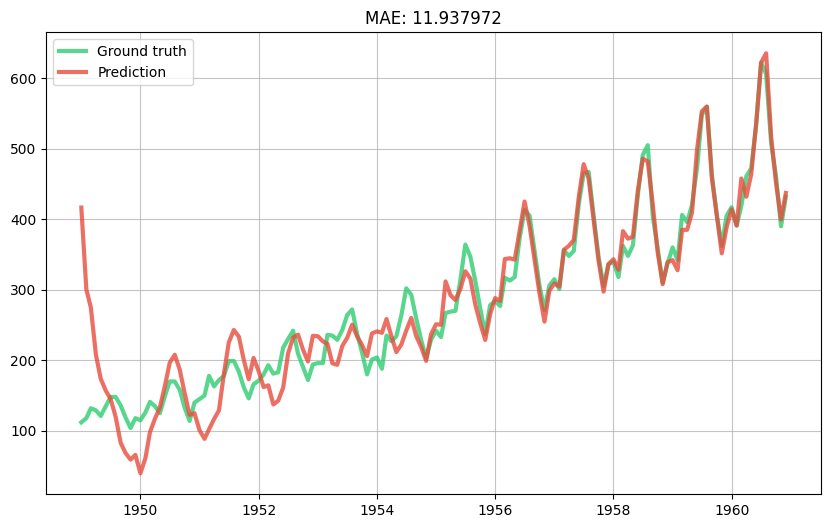

In [6]:
dates, metric, y_trues, y_preds = evaluate_ts_model(model, dataset, time_interval="month", window_size=12)
plot_ts_model(dates, metric, y_trues, y_preds)

### 2 The `fun_hw` from `spotPython`'s `HyperRiver` class

* x0. `alpha`: Smoothing parameter for the level.
* x1. `beta`: Smoothing parameter for the trend.
* x2. `gamma`: Smoothing parameter for the seasonality.
* x3. `seasonality`: The number of periods in a season. For instance, this should be 4 for quarterly data, and 12 for yearly data.
* x4. `multiplicative`: Whether or not to use a multiplicative formulation.

In [7]:
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.data import AirlinePassengers
from numpy import sqrt
from numpy import spacing
eps = sqrt(spacing(1))
lower = np.array([0.2, 0.0125, 0.2, 0, 0])
upper = np.array([0.75, 0.15, 0.7, 12, 1])
var_type=["num", "num", "num", "int", "factor"]
var_name = ["alpha", "beta", "gamma", "seasonality", "multipl"]
dataset = AirlinePassengers()
fun_control = {"horizon": 12,
               "grace_period": None,
               "data": dataset,
               }
fun = HyperRiver(123).fun_hw

### 3 Run the `Spot` Optimizer

* We have chosen `fun_evals = inf` and `max_time = 1`, so that `Spot` runs 1 minute.

In [8]:
spot_hw = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   var_name=var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 15,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 5,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      "log_level": 50
                                      })
spot_hw.run()

spotPython tuning: [##########] 100.00% Done...


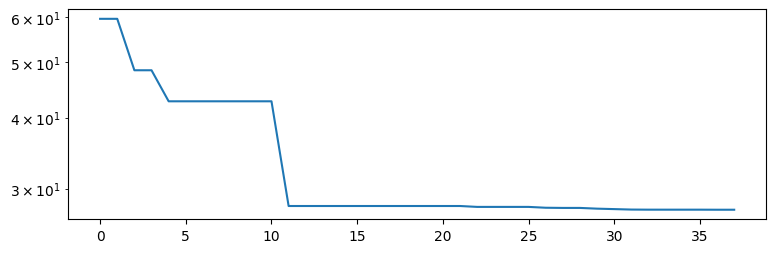

In [9]:
spot_hw.plot_progress(log_y=True)

### 4 Results

In [10]:
spot_hw.print_results()

min y: 27.587814378437493
alpha: 0.5548462639618593
beta: 0.028288461454453687
gamma: 0.38867919276704876
seasonality: 12.0
multipl: 1.0


In [11]:
spot_hw.print_importance()

Importance relative to the most important parameter:
alpha:  0.006218773466606077
beta:  1.1686851196530665
gamma:  0.015791786889831474
seasonality:  100.0
multipl:  0.0007637636214787507


In [12]:
X = spot_hw.to_all_dim(spot_hw.min_X.reshape(1,-1))
print(X)

[[ 0.55484626  0.02828846  0.38867919 12.          1.        ]]


## Detailed Hyperparameter Plots

* For demonstration, we will use the following setting (which gives colorful results):

In [13]:
min_z = None
max_z = None

* For productive use, you might want to select:
  * `min_z=min(spot_hw.y)` and
  * `max_z = max(spot_hw.y)`
* These settings are not so colorful, but give better insights.

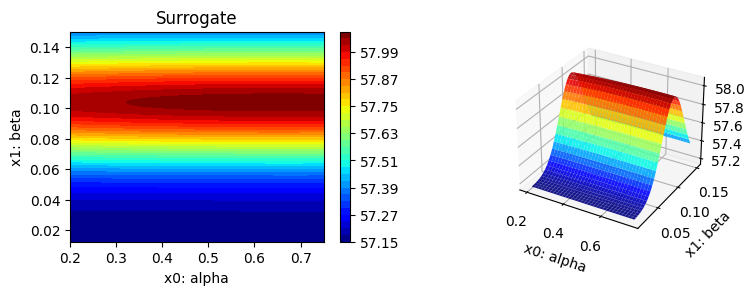

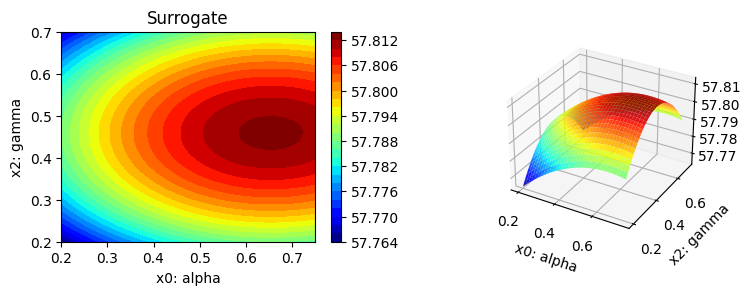

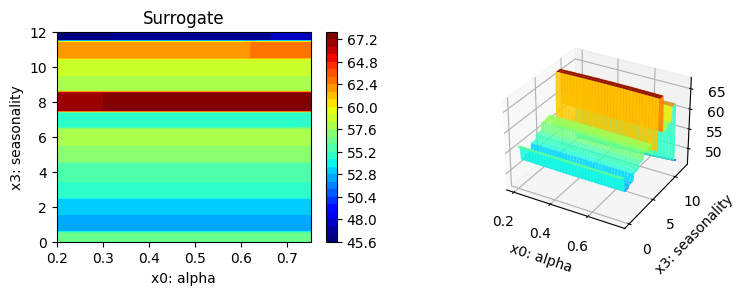

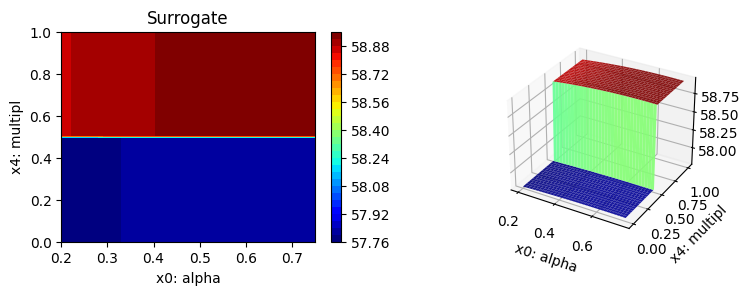

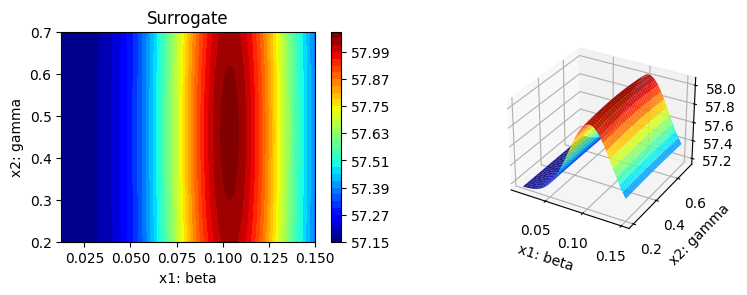

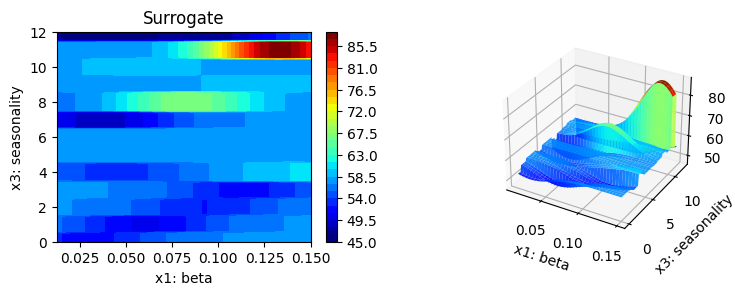

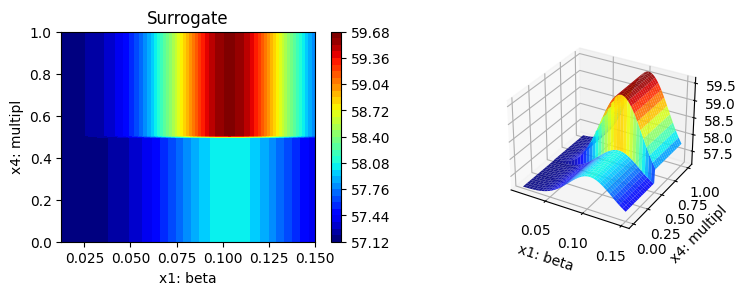

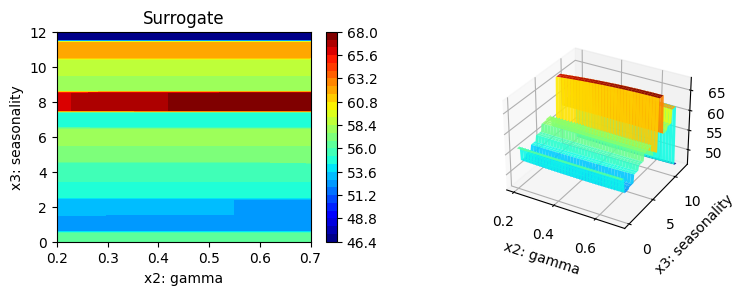

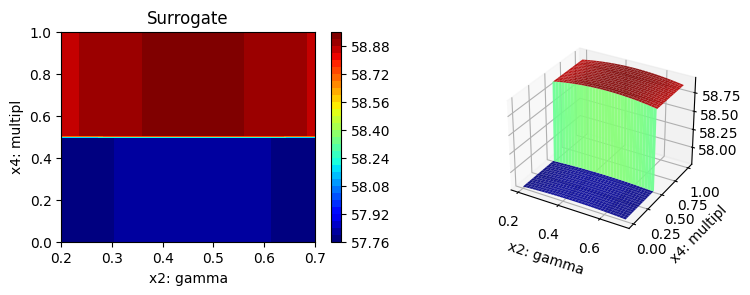

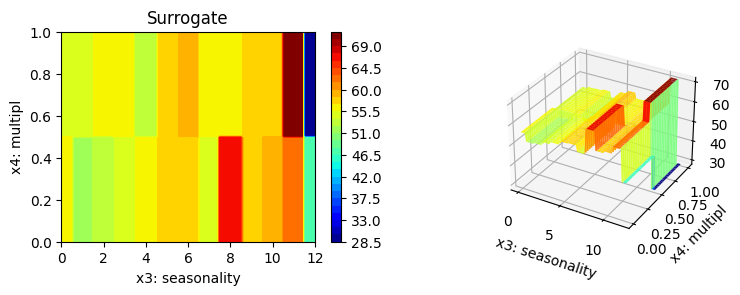

In [14]:
min(spot_hw.y), max(spot_hw.y)
n = spot_hw.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_hw.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)